![logo_ironhack_blue 7](https://user-images.githubusercontent.com/23629340/40541063-a07a0a8a-601a-11e8-91b5-2f13e4e6b441.png)

# PROJECT | Natural Language Processing Challenge

## Introduction

Learning how to process text is a skill required for Data Scientists/AI Engineers. 

In this project, you will put these skills into practice to identify whether a news headline is real or fake news.

## Project Overview

In the file `dataset/data.csv`, you will find a dataset containing news articles with the following columns:

- **`label`**: 0 if the news is fake, 1 if the news is real.
- **`title`**: The headline of the news article.
- **`text`**: The full content of the article.
- **`subject`**: The category or topic of the news.
- **`date`**: The publication date of the article.

Your goal is to build a classifier that is able to distinguish between the two.

Once you have a classifier built, then use it to predict the labels for `dataset/validation_data.csv`. Generate a new file
where the label `2` has been replaced by `0` (fake) or `1` (real) according to your model. Please respect the original file format, 
do not include extra columns, and respect the column separator. 

Please ensure to split the `data.csv` into **training** and **test** datasets before using it for model training or evaluation.

## Guidance

Like in a real life scenario, you are able to make your own choices and text treatment.
Use the techniques you have learned and the common packages to process this data and classify the text.

## Deliverables

1. **Python Code:** Provide well-documented Python code that conducts the analysis.
2. **Predictions:** A csv file in the same format as `validation_data.csv` but with the predicted labels (0 or 1)
3. **Accuracy estimation:** Provide the teacher with your estimation of how your model will perform.
4. **Presentation:** You will present your model in a 10-minute presentation. Your teacher will provide further instructions.

In [74]:
# Can use transformer Model but also need another model
# Can check with other models like Logistic Regression, Random Forest, etc.
# Can find other training data

# Setup the Environment

In [75]:

import nltk
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [76]:
## Read Data
data = pd.read_csv("train_data.csv",encoding='latin-1')

print(data.shape)

print(data.head())

(40399, 5)
   label                                              title  \
0      0  HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...   
1      0  WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...   
2      0  HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...   
3      0  FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...   
4      0  BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...   

                                                text    subject        date  
0  The irony here isn t lost on us. Hillary is be...   politics  2015-03-31  
1  In case you missed it Sen. Harry Reid (R-NV), ...  left-news  2015-03-31  
2  The irony here isn t lost on us. Hillary is be...  left-news  2015-03-31  
3  Just making room for Hillary President Obama t...   politics  2015-03-31  
4  Does anyone really think Hillary Clinton will ...   politics  2015-03-31  


In [77]:
# Reduce the training set to speed up development. 

# data = data.head(1000)

print(data.shape)

(40399, 5)


# Text processing

In [78]:
data.head

<bound method NDFrame.head of        label                                              title  \
0          0  HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...   
1          0  WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...   
2          0  HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...   
3          0  FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...   
4          0  BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...   
...      ...                                                ...   
40394      1  Exclusive: North Korea rules out negotiations ...   
40395      1  Freeport evacuating Indonesian mine worker fam...   
40396      1  Freeport evacuating Indonesian mine worker fam...   
40397      1  Venezuela opposition leader Ledezma flees to S...   
40398      1  As Canada prepares for legal pot, ex-cops get ...   

                                                    text    subject  \
0      The irony here isn t lost on us. Hillary is be...   politics   
1      In case you miss

In [79]:
from nltk.tokenize import word_tokenize

# Tokenize 'title' and 'text' columns and store as new columns
data['title'] = data['title'].apply(lambda x: word_tokenize(str(x)))
data['text'] = data['text'].apply(lambda x: word_tokenize(str(x)))

# Check the result
print(data.head())

   label                                              title  \
0      0  [HILLARY, RODHAM, NIXON, :, A, CANDIDATE, WITH...   
1      0  [WATCH, DIRTY, HARRY, REID, ON, HIS, LIE, ABOU...   
2      0  [HILLARY, RODHAM, NIXON, :, A, CANDIDATE, WITH...   
3      0  [FLASHBACK, :, KING, OBAMA, COMMUTES, SENTENCE...   
4      0  [BENGHAZI, PANEL, CALLS, HILLARY, TO, TESTIFY,...   

                                                text    subject        date  
0  [The, irony, here, isn, t, lost, on, us, ., Hi...   politics  2015-03-31  
1  [In, case, you, missed, it, Sen., Harry, Reid,...  left-news  2015-03-31  
2  [The, irony, here, isn, t, lost, on, us, ., Hi...  left-news  2015-03-31  
3  [Just, making, room, for, Hillary, President, ...   politics  2015-03-31  
4  [Does, anyone, really, think, Hillary, Clinton...   politics  2015-03-31  


In [80]:
title = data['title']
text = data['text']

In [81]:
def clean_text(text: str) -> str:
    # Ensure we are working with a string
    text = str(text)

    # Remove all special characters (keep only letters, numbers, and spaces)
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)

    # Remove all single characters (like "a", "b", "c" standing alone)
    text = re.sub(r"\b[A-Za-z]\b", "", text)

    # Remove single characters from the start of the text
    text = re.sub(r"^[A-Za-z]\s+", "", text)

    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)

    # Convert everything to lowercase
    text = text.lower()

    return text


# clean text
data['text'] = data['text'].apply(clean_text)

# clean title
data['title'] = data['title'].apply(clean_text)

data.head() 


,label,title,text,subject,date
0,0,hillary rodham nixon candidate with more bagga...,the irony here isn lost on us hillary is being...,politics,2015-03-31
1,0,watch dirty harry reid on his lie about romney...,in case you missed it sen harry reid rnv who a...,left-news,2015-03-31
2,0,hillary rodham nixon candidate with more bagga...,the irony here isn lost on us hillary is being...,left-news,2015-03-31
3,0,flashback king obama commutes sentences of 22 ...,just making room for hillary president obama t...,politics,2015-03-31
4,0,benghazi panel calls hillary to testify under ...,does anyone really think hillary clinton will ...,politics,2015-03-31


In [82]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(str(text))
    filtered = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]
    return ' '.join(filtered)

# Make a copy to preserve the original data
data_nostop = data.copy()

# Replace the columns with stopword-removed text
data_nostop['title'] = data_nostop['title'].apply(remove_stopwords)
data_nostop['text'] = data_nostop['text'].apply(remove_stopwords)


In [83]:
data_nostop.head()


,label,title,text,subject,date
0,0,hillary rodham nixon candidate baggage samsoni...,irony lost us hillary compared president wante...,politics,2015-03-31
1,0,watch dirty harry reid lie taxes win,case missed sen harry reid rnv announced last ...,left-news,2015-03-31
2,0,hillary rodham nixon candidate baggage samsoni...,irony lost us hillary compared president wante...,left-news,2015-03-31
3,0,flashback king obama commutes sentences drug d...,making room hillary president obama today anno...,politics,2015-03-31
4,0,benghazi panel calls hillary testify oath whit...,anyone really think hillary clinton come clean...,politics,2015-03-31


In [84]:
# compare

data.head()

,label,title,text,subject,date
0,0,hillary rodham nixon candidate with more bagga...,the irony here isn lost on us hillary is being...,politics,2015-03-31
1,0,watch dirty harry reid on his lie about romney...,in case you missed it sen harry reid rnv who a...,left-news,2015-03-31
2,0,hillary rodham nixon candidate with more bagga...,the irony here isn lost on us hillary is being...,left-news,2015-03-31
3,0,flashback king obama commutes sentences of 22 ...,just making room for hillary president obama t...,politics,2015-03-31
4,0,benghazi panel calls hillary to testify under ...,does anyone really think hillary clinton will ...,politics,2015-03-31


## Stemming and Lemmatization

In [85]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [86]:
data_nostop.head()

,label,title,text,subject,date
0,0,hillary rodham nixon candidate baggage samsoni...,irony lost us hillary compared president wante...,politics,2015-03-31
1,0,watch dirty harry reid lie taxes win,case missed sen harry reid rnv announced last ...,left-news,2015-03-31
2,0,hillary rodham nixon candidate baggage samsoni...,irony lost us hillary compared president wante...,left-news,2015-03-31
3,0,flashback king obama commutes sentences drug d...,making room hillary president obama today anno...,politics,2015-03-31
4,0,benghazi panel calls hillary testify oath whit...,anyone really think hillary clinton come clean...,politics,2015-03-31


In [87]:
def stem_text(text):
    tokens = word_tokenize(str(text))
    return ' '.join([stemmer.stem(word) for word in tokens])

def lemmatize_text(text):
    tokens = word_tokenize(str(text))
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])


In [88]:
# stem the data
data_norm = data_nostop.copy()

data_norm['title'] = data_norm['title'].apply(stem_text)
data_norm['text'] = data_norm['text'].apply(stem_text)

data_norm.head()

,label,title,text,subject,date
0,0,hillari rodham nixon candid baggag samsonit fa...,ironi lost us hillari compar presid want take ...,politics,2015-03-31
1,0,watch dirti harri reid lie tax win,case miss sen harri reid rnv announc last week...,left-news,2015-03-31
2,0,hillari rodham nixon candid baggag samsonit fa...,ironi lost us hillari compar presid want take ...,left-news,2015-03-31
3,0,flashback king obama commut sentenc drug dealer,make room hillari presid obama today announc d...,politics,2015-03-31
4,0,benghazi panel call hillari testifi oath white...,anyon realli think hillari clinton come clean ...,politics,2015-03-31


In [89]:
# lemmatize the data
data_norm['title'] = data_norm['title'].apply(lemmatize_text)
data_norm['text'] = data_norm['text'].apply(lemmatize_text)

data_norm.head()

,label,title,text,subject,date
0,0,hillari rodham nixon candid baggag samsonit fa...,ironi lost u hillari compar presid want take n...,politics,2015-03-31
1,0,watch dirti harri reid lie tax win,case miss sen harri reid rnv announc last week...,left-news,2015-03-31
2,0,hillari rodham nixon candid baggag samsonit fa...,ironi lost u hillari compar presid want take n...,left-news,2015-03-31
3,0,flashback king obama commut sentenc drug dealer,make room hillari presid obama today announc d...,politics,2015-03-31
4,0,benghazi panel call hillari testifi oath white...,anyon realli think hillari clinton come clean ...,politics,2015-03-31


# More manual approach

## Split the data

TimeSeriesSplit: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

"With scikit-learn, you can use TimeSeriesSplit for cross-validation on time series data, but for a simple train/test split (as in your code), you should sort by date and split manually (as shown previously)."

In [90]:
#Manual approach

# Ensure 'date' is a datetime column
# data_norm['date'] = pd.to_datetime(data_norm['date'])

# Sort by date
# data_norm = data_norm.sort_values('date')

# Define the split index
# split_idx = int(len(data_norm) * 0.8)

# Split chronologically
# X = data_norm.drop(['label'], axis=1)
# y = data_norm['label']

# X_train = X.iloc[:split_idx]
# X_test = X.iloc[split_idx:]
# y_train = y.iloc[:split_idx]
# y_test = y.iloc[split_idx:]

# print("Training set shape:", X_train.shape)
# print("Test set shape:", X_test.shape)

## Feature Extraction

## TF_IDF

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
tfidf_vectorizer_text = TfidfVectorizer()

# TF-IDF for 'text'
X_train_text_tfidf = tfidf_vectorizer_text.fit_transform(X_train['text'])
X_test_text_tfidf = tfidf_vectorizer_text.transform(X_test['text'])

# TF-IDF for 'title'
tfidf_vectorizer_title = TfidfVectorizer()
X_train_title_tfidf = tfidf_vectorizer_title.fit_transform(X_train['title'])
X_test_title_tfidf = tfidf_vectorizer_title.transform(X_test['title'])

# Print shapes
print("Text TF-IDF shapes:", X_train_text_tfidf.shape, X_test_text_tfidf.shape)
print("Title TF-IDF shapes:", X_train_title_tfidf.shape, X_test_title_tfidf.shape)  

# Print feature names and first few rows for 'text'
print("Text TF-IDF feature names:", tfidf_vectorizer_text.get_feature_names_out())
print("First 5 rows of text TF-IDF:\n", X_train_text_tfidf[:5].toarray())

# Print feature names and first few rows for 'title'
print("Title TF-IDF feature names:", tfidf_vectorizer_title.get_feature_names_out())
print("First 5 rows of title TF-IDF:\n", X_train_title_tfidf[:5].toarray())


NameError: name 'X_test' is not defined

## Train the Classifier

## Random Forest

In [ ]:
# With title

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_title_tfidf, y_train)

predictions_title = clf.predict(X_test_title_tfidf)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, predictions_title))
print("Classification Report:\n", classification_report(y_test, predictions_title))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions_title))


Accuracy: 0.8535891089108911
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.93      0.67      1302
           1       0.98      0.84      0.91      6778

    accuracy                           0.85      8080
   macro avg       0.76      0.88      0.79      8080
weighted avg       0.91      0.85      0.87      8080

Confusion Matrix:
 [[1211   91]
 [1092 5686]]


In [ ]:
# With text

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_text_tfidf, y_train)

predictions_text = clf.predict(X_test_text_tfidf)

print("Accuracy:", accuracy_score(y_test, predictions_text))
print("Classification Report:\n", classification_report(y_test, predictions_text))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions_text))

Accuracy: 0.9627475247524753
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90      1302
           1       1.00      0.96      0.98      6778

    accuracy                           0.96      8080
   macro avg       0.91      0.98      0.94      8080
weighted avg       0.97      0.96      0.96      8080

Confusion Matrix:
 [[1293    9]
 [ 292 6486]]


In [ ]:
# Combined

from scipy.sparse import hstack

# Combine the TF-IDF features for text and title
X_train_combined = hstack([X_train_text_tfidf, X_train_title_tfidf])
X_test_combined = hstack([X_test_text_tfidf, X_test_title_tfidf])

# Train the classifier on the combined features
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_combined, y_train)

# Predict and evaluate
predictions_combined = clf.predict(X_test_combined)
print("Accuracy:", accuracy_score(y_test, predictions_combined))
print("Classification Report:\n", classification_report(y_test, predictions_combined))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions_combined))

Accuracy: 0.9608910891089109
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89      1302
           1       1.00      0.95      0.98      6778

    accuracy                           0.96      8080
   macro avg       0.90      0.97      0.93      8080
weighted avg       0.97      0.96      0.96      8080

Confusion Matrix:
 [[1292   10]
 [ 306 6472]]


## Logistic Regression

In [ ]:
# With title

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42)
clf.fit(X_train_title_tfidf, y_train)

predictions_title = clf.predict(X_test_title_tfidf)

print("Accuracy:", accuracy_score(y_test, predictions_title))
print("Classification Report:\n", classification_report(y_test, predictions_title))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions_title))


Accuracy: 0.8601485148514851
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.96      0.69      1302
           1       0.99      0.84      0.91      6778

    accuracy                           0.86      8080
   macro avg       0.76      0.90      0.80      8080
weighted avg       0.92      0.86      0.87      8080

Confusion Matrix:
 [[1253   49]
 [1081 5697]]


In [ ]:
# With text

clf = LogisticRegression(random_state=42)
clf.fit(X_train_text_tfidf, y_train)

predictions_text = clf.predict(X_test_text_tfidf)

print("Accuracy:", accuracy_score(y_test, predictions_text))
print("Classification Report:\n", classification_report(y_test, predictions_text))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions_text))

Accuracy: 0.9709158415841584
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.92      1302
           1       1.00      0.97      0.98      6778

    accuracy                           0.97      8080
   macro avg       0.93      0.98      0.95      8080
weighted avg       0.97      0.97      0.97      8080

Confusion Matrix:
 [[1292   10]
 [ 225 6553]]


In [ ]:
# Combined

from scipy.sparse import hstack

# Combine the TF-IDF features for text and title
X_train_combined = hstack([X_train_text_tfidf, X_train_title_tfidf])
X_test_combined = hstack([X_test_text_tfidf, X_test_title_tfidf])

# Train the classifier on the combined features
clf = LogisticRegression(random_state=42)
clf.fit(X_train_combined, y_train)

# Predict and evaluate
predictions_combined = clf.predict(X_test_combined)
print("Accuracy:", accuracy_score(y_test, predictions_combined))
print("Classification Report:\n", classification_report(y_test, predictions_combined))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions_combined))

Accuracy: 0.9804455445544554
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      1302
           1       1.00      0.98      0.99      6778

    accuracy                           0.98      8080
   macro avg       0.95      0.99      0.97      8080
weighted avg       0.98      0.98      0.98      8080

Confusion Matrix:
 [[1293    9]
 [ 149 6629]]


### Transformer Model: DeBERTa v3 

# Approach w/ Cross Validation

## Split the data

In [92]:

from sklearn.model_selection import TimeSeriesSplit

# Ensure datetime and sort by time
data_norm["date"] = pd.to_datetime(data_norm["date"])
data_norm = data_norm.sort_values("date").reset_index(drop=True)

# Features and target
X = data_norm.drop(columns=["label"])
y = data_norm["label"]

# Remove raw date from features for modeling later
X_feat = X.drop(columns=["date"]) if "date" in X.columns else X

# Build time series folds
tscv = TimeSeriesSplit(n_splits=5)

folds = []  # store indices and the sliced data for later use
for fold_id, (tr_idx, va_idx) in enumerate(tscv.split(X_feat), start=1):
    fold = {
        "train_idx": tr_idx,
        "val_idx": va_idx,
        "X_train": X_feat.iloc[tr_idx],
        "X_val": X_feat.iloc[va_idx],
        "y_train": y.iloc[tr_idx],
        "y_val": y.iloc[va_idx],
    }
    folds.append(fold)
    print(f"Fold {fold_id}  train rows {len(tr_idx)}  val rows {len(va_idx)}")

# Example of how to access one fold later
# X_train = folds[0]["X_train"]
# y_train = folds[0]["y_train"]
# X_val   = folds[0]["X_val"]
# y_val   = folds[0]["y_val"]


Fold 1  train rows 6734  val rows 6733
Fold 2  train rows 13467  val rows 6733
Fold 3  train rows 20200  val rows 6733
Fold 4  train rows 26933  val rows 6733
Fold 5  train rows 33666  val rows 6733


In [106]:
X_feat.head()

,title,text,subject
0,hillari rodham nixon candid baggag samsonit fa...,ironi lost u hillari compar presid want take n...,politics
1,watch dirti harri reid lie tax win,case miss sen harri reid rnv announc last week...,left-news
2,hillari rodham nixon candid baggag samsonit fa...,ironi lost u hillari compar presid want take n...,left-news
3,flashback king obama commut sentenc drug dealer,make room hillari presid obama today announc d...,politics
4,benghazi panel call hillari testifi oath white...,anyon realli think hillari clinton come clean ...,politics


## Tf_IDF

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

tfidf_folds = []

for i, fold in enumerate(folds, start=1):
    X_tr = fold["X_train"]
    X_va = fold["X_val"]

    # Fit vectorizers on training only to avoid leakage
    v_text = TfidfVectorizer()
    v_title = TfidfVectorizer()

    X_tr_text = v_text.fit_transform(X_tr["text"].astype(str))
    X_va_text = v_text.transform(X_va["text"].astype(str))

    X_tr_title = v_title.fit_transform(X_tr["title"].astype(str))
    X_va_title = v_title.transform(X_va["title"].astype(str))

    # Combine text and title features
    X_tr_all = hstack([X_tr_text, X_tr_title])
    X_va_all = hstack([X_va_text, X_va_title])

    tfidf_folds.append({
        "X_train_tfidf": X_tr_all,
        "X_val_tfidf": X_va_all,
        "y_train": fold["y_train"].to_numpy(),
        "y_val": fold["y_val"].to_numpy(),
        "vec_text": v_text,
        "vec_title": v_title
    })

    print(f"Fold {i}  train shape {X_tr_all.shape}  val shape {X_va_all.shape}")


Fold 1  train shape (6734, 58974)  val shape (6733, 58974)
Fold 2  train shape (13467, 89256)  val shape (6733, 89256)
Fold 3  train shape (20200, 113548)  val shape (6733, 113548)
Fold 4  train shape (26933, 133802)  val shape (6733, 133802)
Fold 5  train shape (33666, 152612)  val shape (6733, 152612)


## Random Forest

In [100]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

rf_results = []
all_reports = []  # optional, stores per fold classification reports

# Detect if this is a binary task
binary_task = len(np.unique(np.concatenate([f["y_train"] for f in tfidf_folds]))) == 2

for i, f in enumerate(tfidf_folds, start=1):
    X_tr = f["X_train_tfidf"]
    y_tr = f["y_train"]
    X_va = f["X_val_tfidf"]
    y_va = f["y_val"]

    clf_rf = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    )
    clf_rf.fit(X_tr, y_tr)

    preds = clf_rf.predict(X_va)
    acc = accuracy_score(y_va, preds)
    f1 = f1_score(y_va, preds, average="binary" if binary_task else "macro")

    fold_res = {"fold": i, "accuracy": acc, "f1": f1}

    if binary_task:
        proba = clf_rf.predict_proba(X_va)[:, 1]
        auc = roc_auc_score(y_va, proba)
        fold_res["auc"] = auc
        print(f"Fold {i}  acc {acc:.3f}  f1 {f1:.3f}  auc {auc:.3f}")
    else:
        print(f"Fold {i}  acc {acc:.3f}  f1 {f1:.3f}")

    # Optional detailed report and confusion matrix per fold
    rpt = classification_report(y_va, preds)
    cm = confusion_matrix(y_va, preds)
    all_reports.append((i, rpt, cm))

    rf_results.append(fold_res)

# Summary
acc_mean = np.mean([r["accuracy"] for r in rf_results])
acc_std  = np.std([r["accuracy"] for r in rf_results])
f1_mean  = np.mean([r["f1"] for r in rf_results])
f1_std   = np.std([r["f1"] for r in rf_results])

print("\nSummary across folds")
print(f"accuracy mean {acc_mean:.3f}  std {acc_std:.3f}")
print(f"f1 mean {f1_mean:.3f}  std {f1_std:.3f}")
if binary_task:
    auc_mean = np.mean([r["auc"] for r in rf_results])
    auc_std  = np.std([r["auc"] for r in rf_results])
    print(f"auc mean {auc_mean:.3f}  std {auc_std:.3f}")

# If you want to see one fold report and confusion matrix
k = 0  # change to another index to inspect a different fold
fold_id, report, cmatrix = all_reports[k]
print(f"\nClassification report for fold {fold_id}:\n{report}")
print(f"Confusion matrix for fold {fold_id}:\n{cmatrix}")


Fold 1  acc 0.908  f1 0.800  auc 0.998
Fold 2  acc 0.962  f1 0.937  auc 0.999
Fold 3  acc 0.982  f1 0.978  auc 0.999
Fold 4  acc 0.921  f1 0.929  auc 0.996
Fold 5  acc 0.984  f1 0.990  auc 0.999

Summary across folds
accuracy mean 0.951  std 0.032
f1 mean 0.927  std 0.067
auc mean 0.998  std 0.001

Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      4864
           1       1.00      0.67      0.80      1869

    accuracy                           0.91      6733
   macro avg       0.94      0.83      0.87      6733
weighted avg       0.92      0.91      0.90      6733

Confusion matrix for fold 1:
[[4864    0]
 [ 622 1247]]


In [109]:
# save model
import joblib
joblib.dump(clf_rf, "modelRF.pkl")
joblib.dump(v_text, "vectorizer_text.pkl")
joblib.dump(v_title, "vectorizer_title.pkl")


['vectorizer_title.pkl']

## Logistic Regression

In [107]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

lr_results = []
all_reports = []

# Detect if this is a binary task
binary_task = len(np.unique(np.concatenate([f["y_train"] for f in tfidf_folds]))) == 2

for i, f in enumerate(tfidf_folds, start=1):
    X_tr = f["X_train_tfidf"]
    y_tr = f["y_train"]
    X_va = f["X_val_tfidf"]
    y_va = f["y_val"]

    # Sparse friendly solver, works for binary and multiclass
    clf_lr = LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="saga",
        penalty="l2"
    )
    clf_lr.fit(X_tr, y_tr)

    preds = clf_lr.predict(X_va)
    acc = accuracy_score(y_va, preds)
    f1 = f1_score(y_va, preds, average="binary" if binary_task else "macro")

    fold_res = {"fold": i, "accuracy": acc, "f1": f1}

    if binary_task:
        proba = clf_lr.predict_proba(X_va)[:, 1]
        auc = roc_auc_score(y_va, proba)
        fold_res["auc"] = auc
        print(f"Fold {i}  acc {acc:.3f}  f1 {f1:.3f}  auc {auc:.3f}")
    else:
        print(f"Fold {i}  acc {acc:.3f}  f1 {f1:.3f}")

    rpt = classification_report(y_va, preds)
    cm = confusion_matrix(y_va, preds)
    all_reports.append((i, rpt, cm))

    lr_results.append(fold_res)

# Summary
acc_mean = np.mean([r["accuracy"] for r in lr_results])
acc_std  = np.std([r["accuracy"] for r in lr_results])
f1_mean  = np.mean([r["f1"] for r in lr_results])
f1_std   = np.std([r["f1"] for r in lr_results])

print("\nSummary across folds")
print(f"accuracy mean {acc_mean:.3f}  std {acc_std:.3f}")
print(f"f1 mean {f1_mean:.3f}  std {f1_std:.3f}")
if binary_task:
    auc_mean = np.mean([r["auc"] for r in lr_results])
    auc_std  = np.std([r["auc"] for r in lr_results])
    print(f"auc mean {auc_mean:.3f}  std {auc_std:.3f}")

# Inspect one fold
k = 0
fold_id, report, cmatrix = all_reports[k]
print(f"\nClassification report for fold {fold_id}:\n{report}")
print(f"Confusion matrix for fold {fold_id}:\n{cmatrix}")

Fold 1  acc 0.976  f1 0.956  auc 0.997
Fold 2  acc 0.982  f1 0.973  auc 0.999
Fold 3  acc 0.985  f1 0.982  auc 0.999
Fold 4  acc 0.964  f1 0.969  auc 0.997
Fold 5  acc 0.990  f1 0.994  auc 0.999

Summary across folds
accuracy mean 0.980  std 0.009
f1 mean 0.975  std 0.013
auc mean 0.998  std 0.001

Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4864
           1       0.98      0.94      0.96      1869

    accuracy                           0.98      6733
   macro avg       0.98      0.96      0.97      6733
weighted avg       0.98      0.98      0.98      6733

Confusion matrix for fold 1:
[[4821   43]
 [ 119 1750]]


In [108]:
# save model

import joblib
joblib.dump(clf_lr, "modelLR.pkl")   # save

['modelLR.pkl']

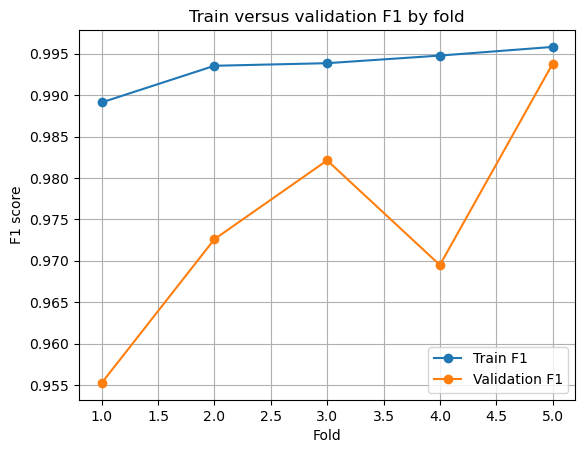

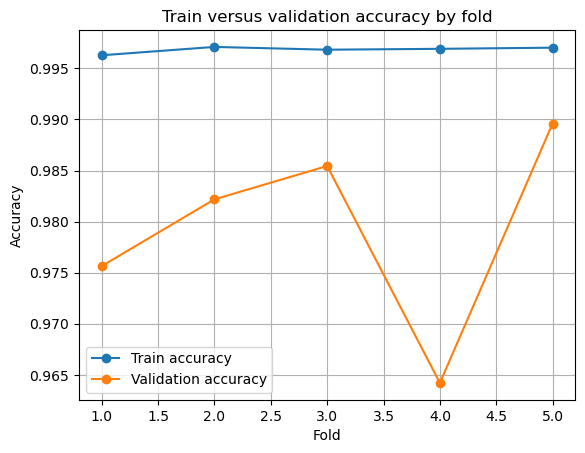

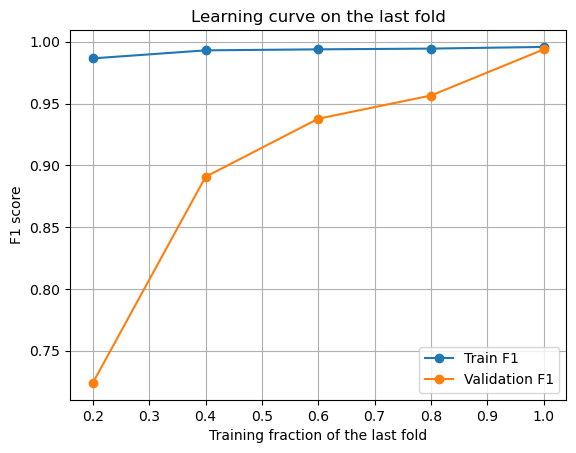

In [ ]:


# Plot train versus validation F1 by fold
plt.figure()
xs = list(range(1, len(tfidf_folds) + 1))
plt.plot(xs, train_f1s, marker="o", label="Train F1")
plt.plot(xs, val_f1s, marker="o", label="Validation F1")
plt.xlabel("Fold")
plt.ylabel("F1 score")
plt.title("Train versus validation F1 by fold")
plt.grid(True)
plt.legend()
plt.show()

# Optional second view, accuracy by fold
plt.figure()
plt.plot(xs, train_accs, marker="o", label="Train accuracy")
plt.plot(xs, val_accs, marker="o", label="Validation accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Train versus validation accuracy by fold")
plt.grid(True)
plt.legend()
plt.show()

# Learning curve on the last fold
fold = tfidf_folds[-1]
X_tr = fold["X_train_tfidf"]; y_tr = fold["y_train"]
X_va = fold["X_val_tfidf"];   y_va = fold["y_val"]

fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
val_curve, train_curve = [], []

for frac in fractions:
    n = max(1, int(len(y_tr) * frac))
    clf = LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="saga",
        penalty="l2"
    ).fit(X_tr[:n], y_tr[:n])

    pred_va = clf.predict(X_va)
    pred_tr = clf.predict(X_tr[:n])

    val_curve.append(f1_score(y_va, pred_va))
    train_curve.append(f1_score(y_tr[:n], pred_tr))

plt.figure()
plt.plot(fractions, train_curve, marker="o", label="Train F1")
plt.plot(fractions, val_curve, marker="o", label="Validation F1")
plt.xlabel("Training fraction of the last fold")
plt.ylabel("F1 score")
plt.title("Learning curve on the last fold")
plt.grid(True)
plt.legend()
plt.show()
